# Proccessing all the images from the week

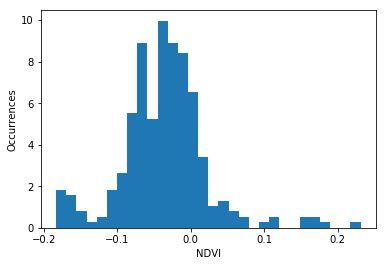

In [8]:
import os
import numpy as np
import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from skimage.filters import gaussian
from PIL import Image
import copy
import pylab


def plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='Greys'):
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

        
def getNDVI(filenameNoIR,filenameIR,dateM):
    # Pon aqui todo el metodo, calcula todas las imagenes y haz la presentacion :)
    #print (dateM)
    # Proccessing IR Image
    im = Image.open(filenameIR)
    newNamefilenameIR = filenameIR.split('.')
    fileIR = newNamefilenameIR[0]
    #print (fileIR)
    # TIFF generated
    im.save(fileIR + '.tiff')
    # Open with GDAL
    chm_filename = filenameIR
    chm_dataset = gdal.Open(chm_filename)
    # Convert into spatial extent
    chm_mapinfo = chm_dataset.GetGeoTransform()
    xMin = chm_mapinfo[0]
    yMax = chm_mapinfo[3]

    xMax = xMin + chm_dataset.RasterXSize/chm_mapinfo[1] #divide by pixel width 
    yMin = yMax + chm_dataset.RasterYSize/chm_mapinfo[5] #divide by pixel height (note sign +/-)
    chm_ext = (xMin,xMax,yMin,yMax)
    #print('Raster extent:',chm_ext)   
    
    cols = chm_dataset.RasterXSize; 
    #print('# of columns:',cols)
    rows = chm_dataset.RasterYSize; 
    #print('# of rows:',rows)
    #print('# of bands:',chm_dataset.RasterCount)
    #print('driver:',chm_dataset.GetDriver().LongName)

    chm_raster = chm_dataset.GetRasterBand(2)
    scaleFactor = 1.0
    #print('scale factor:',scaleFactor)
    
    chm_array_2 = chm_dataset.GetRasterBand(2).ReadAsArray(0,0,cols,rows).astype(np.float)
    chm_array_2=chm_array_2/scaleFactor
    chm_array_2=chm_array_2[97:rows,:]
    #print('Array:\n',chm_array_2) #display array values
    array_ir_smooth = gaussian(chm_array_2,3)
    #plot_band_array(array_ir_smooth,chm_ext,(0,80),title='Plot',cmap_title='chm_array_2, m')
    
    # Processing of RGB image
    im = Image.open(filenameNoIR)
    newNamefilenameNoIR = filenameNoIR.split('.')
    fileNoIR = newNamefilenameNoIR[0]
    #print (fileNoIR)
    # TIFF generated
    im.save(fileNoIR + '.tiff')
    chm_filename2 = filenameNoIR
    chm_dataset2 = gdal.Open(chm_filename2)
    cols = chm_dataset2.RasterXSize; 
    #print('# of columns:',cols)
    rows = chm_dataset2.RasterYSize; 
    #print('# of rows:',rows)
    #print('# of bands:',chm_dataset2.RasterCount)
    #print('driver:',chm_dataset2.GetDriver().LongName)

    chm_array_10 = chm_dataset2.GetRasterBand(1).ReadAsArray(0,0,cols,rows).astype(np.float)
    #### chm_array[chm_array==int(noDataVal)]=np.nan #Assign CHM No Data Values to NaN
    chm_array_10=chm_array_10/scaleFactor
    chm_array_10=chm_array_10[97:rows,:]
    #print('Array:\n',chm_array_10) #display array values

    colorlimit = (0,256) # set color from 0-256

    # Blur the array in order to avoid the noise
    array_vis_smooth = gaussian(chm_array_10,3)
    #plot_band_array(array_vis_smooth,chm_ext,colorlimit,title='SERC Band 58(Red)',colormap='Reds_r')

    vis = array_vis_smooth.astype(float)
    nir = array_ir_smooth.astype(float) 
    
    ndvi = np.divide((nir-vis),(nir+vis))
    #plot_band_array(ndvi,chm_ext,(0,np.max(ndvi)),title='Subset NDVI \n (VIS, NIR)',cmap_title='NDVI',colormap='seismic')
    #pylab.savefig('NDVI/'+dateM+'.png')   

    ndvi_valor = np.nanmean(ndvi,dtype=np.float64)
    
    return (ndvi_valor)







def main():
    NDVIvalues = []
    directoryIR = 'IR/'
    directoryNoIR = 'NoIR/'
    file_list = os.listdir(directoryNoIR)
    #filenameIR = 'cperuvb_IR_2016_06_21_083005.jpg'
    for filenameIR in os.listdir(directoryIR): # Es un for para coger todos los archivos!!!
        if filenameIR.endswith(".jpg"): 
            a= filenameIR.split('_')
            irFile = a[3]+'_'+a[4]+'_'+a[5]
            nameFo= irFile.split('.')
            nameF = nameFo[0]
            #print (nameF)
            filenameNoIR = 'cperuvb_2016_'+irFile
            if filenameNoIR in file_list:
                #print (filenameNoIR)
                #print (filenameIR)
                ir= directoryIR + filenameIR
                noir= directoryNoIR + filenameNoIR
                #print (ir)
                #print (noir)
                valueNDVI = getNDVI(noir,ir,nameF)
                #print (valueNDVI)
                NDVIvalues.append(valueNDVI)
                
    #print ("NDVI Values:")
    #print (NDVIvalues)
    plt.hist(NDVIvalues, normed=True, bins=30)
    plt.xlabel('NDVI');
    plt.ylabel('Occurrences');
    pylab.savefig('result.png')  
    ndvi_valor = np.nanmean(NDVIvalues,dtype=np.float64)
    #print ("Week Average value:")
    #print (ndvi_valor)    
        
        

if  __name__ =='__main__':main()
    


    

# Week Average value:
# -0.0361375375733